<h1 align="center">CNN</h1>

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import time
from sklearn.model_selection import train_test_split
import torch.nn as nn
import seaborn as sns
import torchvision.datasets
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,accuracy_score,multilabel_confusion_matrix
from flopth import flopth
from sklearn.decomposition import PCA
from  sklearn.manifold import TSNE

In [2]:
dataset_path = "/lung_colon_image_set"

# Define the transformation to be applied to each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to a fixed size
    transforms.ToTensor(),           # Convert image to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize image pixel values
])


# Create a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.classes = []
        self.images = []
        self.labels = []
        self._load_images()
        self.encoder = LabelEncoder()

    def _load_images(self):
        for dirname,_, filenames in os.walk('lung_colon_image_set'):
            for filename in filenames:
                if not filename.lower().endswith('.ds_store'):
                    if "lung_aca" in dirname:
                        self.classes.append("Lung Adenocarcinoma")
                    elif "lung_n" in dirname:
                        self.classes.append("Lung Benign Tissue")
                    elif "lung_scc" in dirname:
                        self.classes.append("Lung Squamous Cell Carcinoma")
                    elif "colon_n" in dirname:
                        self.classes.append("Colon Benign Tissue")
                    elif "colon_aca" in dirname:
                        self.classes.append("Colon Adenocarcinoma")
                    self.images.append(os.path.join(dirname, filename))
        
    def __getitem__(self, index):
        image_path = self.images[index]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        self.labels = self.encoder.fit_transform(self.classes)
        label = self.labels[index]
        return image, label

    def __len__(self):
        return len(self.images)

# Create the custom dataset
dataset = CustomDataset(dataset_path, transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
print("dataset size", len(dataset))
print("train size", train_size)
if train_size > 0:  # Check if training set is not empty
    train_dataset, val_dataset = train_test_split(dataset, test_size = 0.2)
    val_dataset, test_dataset = train_test_split(train_dataset, test_size = 0.5)

    # Create dataloaders for training and validation sets
    batch_size = 32
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
else:
    print("Training set is empty. Please adjust the split ratios or check the dataset.")

dataset size 25000
train size 20000


In [3]:
len(train_dataloader) * 32

20000

In [4]:
len(val_dataloader)

10000

In [7]:
tic = time.time()

num_epochs = 10
num_classes = 5
learning_rate = 0.01


class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.fc_layer = nn.Sequential(
            nn.Linear(15376, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 5),
        )
        
    def forward(self, x):

        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)
        return x

def val_model(model):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Validation Accuracy of the model on the 2500 images: {} %'.format((correct / total) * 100))
    return (correct / total)

def test_model(model):
    model.eval()
    predicted_labels = []
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            predicted_labels.append(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Test Accuracy of the model on the 2500 images: {} %'.format((correct / total) * 100))
    return (correct / total),predicted_labels

model = CNN()


In [8]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_dataloader)
loss_list = []
acc_list = []
per_epoch_loss_list = []
per_epoch_acc_list = []
test_per_epoch_acc_list = []
val_per_epoch_acc_list =[]

for epoch in range(num_epochs):
    epoch_no_correct=0
    epoch_total=0
    epoch_loss=0
    for i,(images, labels) in enumerate(train_dataloader):
        # Forward pass
        
        outputs = model(torch.tensor(images))
        
        loss = criterion(outputs, torch.tensor(labels))
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)
        epoch_no_correct +=correct
        epoch_total +=total
        epoch_loss += loss.item()

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))
        
    per_epoch_loss_list.append(epoch_loss/len(train_dataloader))
    per_epoch_acc_list.append(epoch_no_correct/epoch_total)

    val_acc_per_epoch = val_model(model)
    val_per_epoch_acc_list.append(val_acc_per_epoch)
    
    test_acc_per_epoch,predicted_labels = test_model(model)
    test_per_epoch_acc_list.append(test_acc_per_epoch)


print("LOSS: " +str(per_epoch_loss_list))
print("EPOCH:" +str(per_epoch_acc_list))
print("VALIDATION ACCURACY: "+ str(val_per_epoch_acc_list))
print("TEST ACCURACY:" +str(test_per_epoch_acc_list))

/var/folders/_8/v_k1l3v15lgdd2d4xvnt3kzc0000gn/T/ipykernel_6226/1787490699.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = model(torch.tensor(images))
/var/folders/_8/v_k1l3v15lgdd2d4xvnt3kzc0000gn/T/ipykernel_6226/1787490699.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(labels))


Epoch [1/10], Step [100/625], Loss: 1.1546, Accuracy: 62.50%
Epoch [1/10], Step [200/625], Loss: 0.7284, Accuracy: 71.88%
Epoch [1/10], Step [300/625], Loss: 0.6732, Accuracy: 75.00%
Epoch [1/10], Step [400/625], Loss: 0.3238, Accuracy: 84.38%
Epoch [1/10], Step [500/625], Loss: 0.1606, Accuracy: 93.75%
Epoch [1/10], Step [600/625], Loss: 0.4307, Accuracy: 75.00%
Validation Accuracy of the model on the 2500 images: 83.36 %
Test Accuracy of the model on the 2500 images: 82.63000000000001 %
Epoch [2/10], Step [100/625], Loss: 0.3956, Accuracy: 93.75%
Epoch [2/10], Step [200/625], Loss: 0.4848, Accuracy: 81.25%
Epoch [2/10], Step [300/625], Loss: 0.2419, Accuracy: 93.75%
Epoch [2/10], Step [400/625], Loss: 0.4692, Accuracy: 78.12%
Epoch [2/10], Step [500/625], Loss: 0.1749, Accuracy: 96.88%
Epoch [2/10], Step [600/625], Loss: 0.3521, Accuracy: 87.50%
Validation Accuracy of the model on the 2500 images: 81.76 %
Test Accuracy of the model on the 2500 images: 81.66 %
Epoch [3/10], Step [100/

In [9]:
print("TRAIN ACCURACY OF CNN: " + str(sum(per_epoch_acc_list)/len(test_per_epoch_acc_list) * 100) +"%")
#VALIDATION ACCURACY
print("VALIDATION ACCURACY OF CNN: " + str(sum(val_per_epoch_acc_list)/len(test_per_epoch_acc_list) * 100) +"%")
#TEST ACCURACY
print("TEST ACCURACY OF CNN: " + str(sum(test_per_epoch_acc_list)/len(test_per_epoch_acc_list) * 100) +"%")

TRAIN ACCURACY OF CNN: 91.92949999999999%
VALIDATION ACCURACY OF CNN: 91.95%
TEST ACCURACY OF CNN: 91.996%


In [10]:
model.eval()

CNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=15376, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=16, out_features=5, bias=True)
  )
)

### ACCURACY PLOT

Text(0.5, 1.0, 'Accuraciees of CNN')

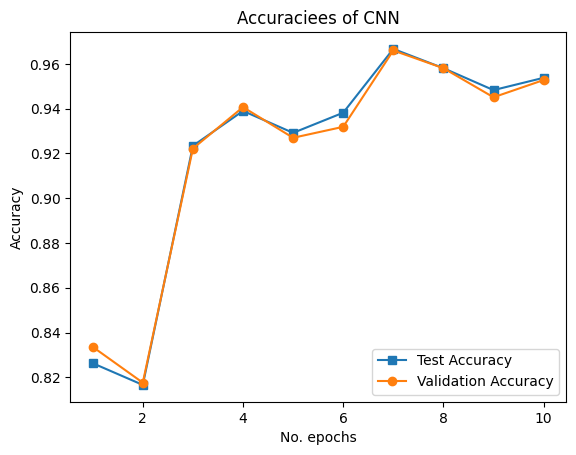

In [23]:
plt.plot(range(1,num_epochs+1),test_per_epoch_acc_list, marker='s') 
plt.plot(range(1,num_epochs+1),val_per_epoch_acc_list, marker='o') 
plt.legend([ 'Test Accuracy',"Validation Accuracy"], loc='lower right')
plt.xlabel('No. epochs')
plt.ylabel('Accuracy')
plt.title('Accuraciees of CNN')

In [65]:
def pred_labels(model):
    model.eval()
    pred_classes = []
    original_classes = []
    for images, labels in test_dataloader:
        outputs = model(images)
        flops, params = flopth(model, inputs=(images,),show_detail=True)
        print(flops, params)
        break
        for out in outputs:
            pred_classes.append(np.argmax(out.detach().numpy()))
        for label in labels:
            original_classes.append(label)
    return [pred_classes,original_classes]

In [42]:
test_labels = pred_labels(model)

In [43]:
cat_list = ["Lung Adenocarcinoma",
"Lung Benign Tissue",
"Lung Squamous Cell Carcinoma",
"Colon Benign Tissue",
"Colon Adenocarcinoma"]
pred_classes = [cat_list[i] for i in test_labels[0]]
original_classes = [cat_list[i] for i in test_labels[1]]

### CLASSIFICATION REPORT

In [44]:
print(classification_report(original_classes,pred_classes))

                              precision    recall  f1-score   support

        Colon Adenocarcinoma       0.92      0.96      0.94      2050
         Colon Benign Tissue       1.00      0.99      0.99      1953
         Lung Adenocarcinoma       1.00      0.91      0.95      2027
          Lung Benign Tissue       0.91      1.00      0.96      1987
Lung Squamous Cell Carcinoma       0.95      0.91      0.93      1983

                    accuracy                           0.95     10000
                   macro avg       0.96      0.95      0.95     10000
                weighted avg       0.96      0.95      0.95     10000



### CONFUSION MATRIX

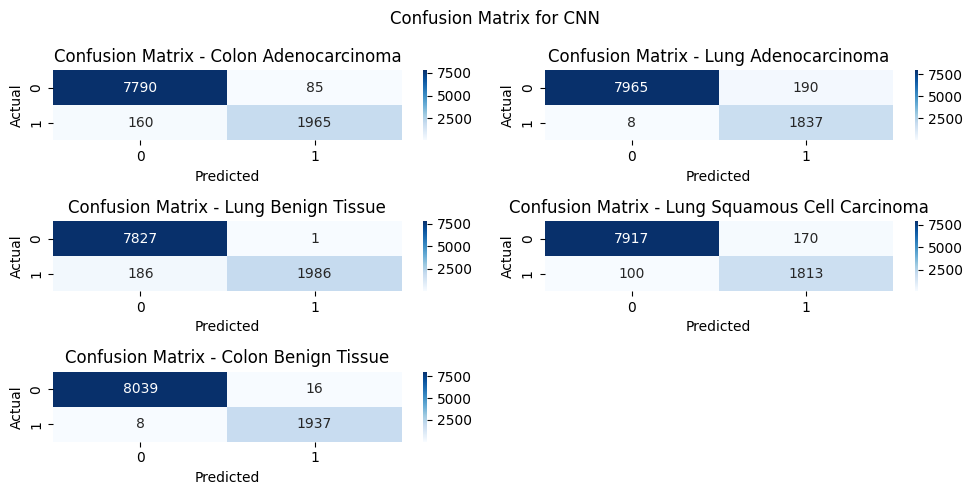

In [48]:
cnf_matrix = multilabel_confusion_matrix(test_labels[0], test_labels[1])
np.set_printoptions(precision=2)
num_labels = len(cnf_matrix)

# Calculate the number of rows and columns needed based on the available labeled data
num_rows = (num_labels+1) // 2
num_cols = min(2, num_labels)

# Plotting the confusion matrix
fig, axes = plt.subplots(nrows=num_rows,ncols=num_cols, figsize=(10, 5))
labels = np.unique(test_labels[0]) # Replace with your label names

for i,ax in enumerate(axes.flat):
    if i < num_labels:
        sns.heatmap(cnf_matrix[i-1], annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.set_title(f'Confusion Matrix - {cat_list[i-1]}')
    else:
        # Remove any unused subplots
        fig.delaxes(ax)

plt.suptitle("Confusion Matrix for CNN")
plt.tight_layout()
plt.show()

### TNSE

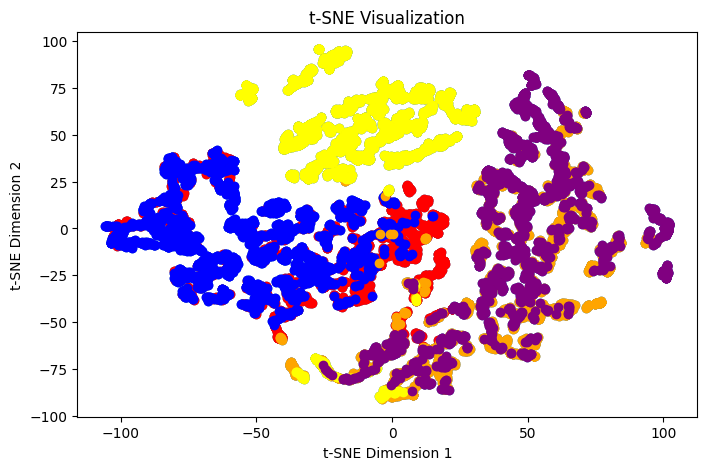

In [59]:
testX = []
for item in test_dataset:
    testX.append(np.array(item[0]).flatten())
pca = PCA(n_components=2)
pca_result = pca.fit_transform(testX)
tsne = TSNE(n_components=2)
tsne_values = tsne.fit_transform(pca_result)

# Extract x and y coordinates from t-SNE values
x = tsne_values[:, 0]
y = tsne_values[:, 1]

# Create a scatter plot of the t-SNE graph
plt.figure(figsize=(8, 5))
plt.scatter(x, y)

# Add labels or color based on your dataset
labels = test_labels[1]
unique_labels = np.unique(test_labels[0])
num_labels = len(unique_labels)
colors = ["red","blue","orange","yellow","purple"]

for i, label in enumerate(unique_labels):
    indices = np.where(labels == label)
    plt.scatter(x[indices], y[indices], color=colors[i], label=label)


plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization')
plt.show()

### FLOPS

In [66]:
pred_labels(model) # for only one batch

+---------------+---------------+------------+-------------+----------+------------------+---------------------------------------------------+----------+-----------------+----------------------------------------+
| module_name   | module_type   | in_shape   | out_shape   | params   | params_percent   | params_percent_vis                                | flops    | flops_percent   | flops_percent_vis                      |
+===============+===============+============+=============+==========+==================+===================================================+==========+=================+========================================+
| conv_layer.0  | Conv2d        | (3,64,64)  | (16,64,64)  | 448.0    | 0.0904121%       |                                                   | 58.7203M | 15.2259%        | #######                                |
+---------------+---------------+------------+-------------+----------+------------------+---------------------------------------------------+------

[[], []]

In [67]:
torch.save(model.state_dict(),"CNN.pt")